# Transfer Learning

With transfer learning, we take a pre-trained model and retrain it on a task that has some overlap with the original training task.


Transfer learning is especially powerful when we do not have a large and varied dataset. In this case, a model trained from scratch would likely memorize the training data quickly, but not be able to generalize well to new data. With transfer learning, we can increase our chances of training an accurate and robust model on a small dataset.

## Downloading the Pretrained Model

The ImageNet pre-trained models are often good choices for computer vision transfer learning, as they have learned to classify many many different types of images. In doing this, they have learned to detect many different types of features that could be valuable in image recognition.

We'll start by downloading the pre-trained model.  In our case, we want it to make a different classification: with Mask or not? Because we want the classification to be different, we are going to remove the last layer of the model. We can do this by setting the flag `include_top=False` when downloading the model. After removing this top layer, we can add new layers that will yield the type of classification that we want:

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [2]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Freezing the Base Model
Before we add our new layers onto the pre-trained model, we should take an important step: freezing the model's pre-trained layers. This means that when we train, we will not update the base layers from the pre-trained model. Instead we will only update the new layers that we add on the end for our new classification. We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset. If they were unfrozen at this stage, we would likely destroy this valuable information. There will be an option to unfreeze and train these layers later, in a process called fine-tuning.

Freezing the base layers is as simple as setting trainable on the model to false.

In [3]:
base_model.trainable = False

## Adding New Layers

We can now add the new trainable layers on top of the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We'll add two layers to the model. First will be a pooling layer like we saw in our earlier convolutional neural network. We then need to add our final layer, which will classify with or wothout Mask. This will be a densely connected layer with one output.

In [4]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to ase 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

Let's take a look at the model, now that we've combined the pre-trained model with the new layers.

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## Compiling the Model

Now we need to compile the model with loss and metrics options. In our case we only have a binary classification problem (with or whithout Mask), and so we'll use binary crossentropy. . We will also use binary accuracy instead of traditional accuracy.

By setting `from_logits=True` we inform the loss function that the output values are not normalized.

In [6]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

## Augmenting the Data

Now that we're dealing with a very small dataset, it's especially important that we augment our data. W'll make small modifications to the existing images, which will allow the model to see a wider variety of images to learn from. This will help it learn to recognize new pictures of Bo instead of just memorizing the pictures it trains on.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

## Loading the Data

We're going to load images directly from folders using Keras' `flow_from_directory` function. We've set up our directories to help this process go smoothly. In the `mask-data` directory, we have train and test directories, which each have folders for images of with mask and whithout mask. 

Note that flow_from_directory will also allow us to size our images to match the model: 244x244 pixels with 3 channels.

In [11]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('mask-data/train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate test dataset
test_it = datagen.flow_from_directory('mask-data/test/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 70 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## Training the Model

Now it's time to train our model and see how it does. Recall that when using a data generator, we have to explicitly set the number of `steps_per_epoch`:

In [12]:
model.fit(train_it, steps_per_epoch=12, validation_data=test_it, validation_steps=4, epochs=20)

C:\Users\HP\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
12/12 [==============================] - 33s 2s/step - loss: 0.9651 - binary_accuracy: 0.6788 - val_loss: 0.5573 - val_binary_accuracy: 0.8333


## Fine-Tuning the Model

Now that the new layers of the model are trained, we have the option to apply a final trick to improve the model, called fine-tuning. To do this we unfreeze the entire model, and train it again with a very small learning rate. This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.  

Note that it's important to only do this step after the model with frozen layers has been fully trained. The untrained pooling and classification layers that we added to the model earlier were randomly initialized. This means they needed to be updated quite a lot to correctly classify the images. Through the process of backpropagation, large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.


In [13]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [14]:
model.fit(train_it, steps_per_epoch=12, validation_data=test_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 67s 5s/step - loss: 0.6112 - binary_accuracy: 0.8021 - val_loss: 1.0351 - val_binary_accuracy: 0.7000


## Examining the Predictions

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

Let's try this out on a couple images to see the predictions:

array([[-0.8392527]], dtype=float32)

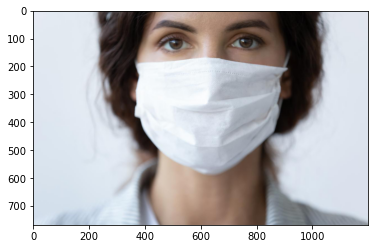

In [17]:
make_predictions('mask-data/test/with_mask/Facemask.jpg')

array([[5.060939]], dtype=float32)

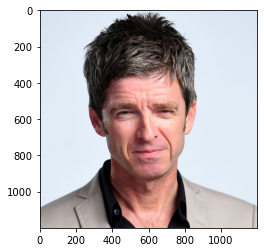

In [18]:
make_predictions('mask-data/test/without_mask/3500.jpg')

It looks like a negative number prediction means that it's with mask and a positive number prediction means it's without mask. We can use this information to have our mask door only let person with mask in! 

## Mask Door

Fill in the following code to implement people with mask's door:

In [19]:
def with_mask_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("With mask! Let him in!")
    else:
        print("Without mask! Stay out!")

Let's try it out!

With mask! Let him in!


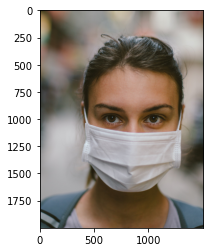

In [22]:
with_mask_door('mask-data/test/with_mask/mask.jpg')

Without mask! Stay out!


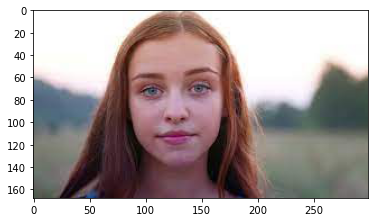

In [25]:
with_mask_door('mask-data/test/without_mask/images.jpg')

## Summary

With transfer learning, we've built a highly accurate model using a very small dataset. This can be an extremely powerful technique, and be the difference between a successful project and one that can't get off the ground. 